In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import partial_dependence
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

In [4]:
import os

dir_name = os.path.abspath('.')
dir_name

'f:\\Code\\python\\python_qiang\\gbdt'

In [5]:
csv_file = os.path.join(dir_name, 'new_data.csv')

# 加载CSV数据
data = pd.read_csv(os.path.join(dir_name, 'new_data.csv'), encoding='gb2312')
data = data[data['Distance'] > 40]

# 对data的所有非数值列进行log运算
data = data.apply(lambda x: np.log(x) if np.issubdtype(x.dtype, np.number) else x)

f:\Code\python\python_qiang\env\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [15]:
from scipy.interpolate import splev, splrep  # 数据平滑插值
from sklearn.inspection import PartialDependenceDisplay


def plot_partial_depency(model, data, features_index: list = [0], axs: list = [], legends: list = [], linestyle: str = '-'):
    # 使用pdp计算部分依赖值
    # PartialDependenceDisplay.from_estimator(model, data, features_index, grid_resolution=100, kind='both')
    pd_results = partial_dependence(model, data, features_index, kind='both', percentiles=(0, 1), grid_resolution=1000)

    # 绘制部分依赖曲线

    for i, ax in enumerate(axs):
        plot_x = pd_results['values'][i] # 提取值作为x轴
        plot_y = pd_results['average'][i] # 提取平均pdp作为y轴数据
        # tck = splrep(plot_x, plot_y, s=30) # 进行数据平滑，参考：https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html?highlight=interpolate
        # xnew = np.linspace(plot_x.min(),plot_x.max(),1000)
        # ynew = splev(xnew, tck, der=0)
        ax.plot(plot_x, plot_y, label=legends[i], linestyle=linestyle)
        ax.set_xlabel('ln(城际距离)/公里')
        ax.set_ylabel('ln(城际联系)/人次')

        ax.legend()

In [7]:
def pred_plot(model, X: pd.DataFrame, y: np.ndarray, province: str):
    y_pred = model.predict(X)
    plot_x = X['Distance'].to_numpy()
    plot_val_y = y.ravel()
    sorted_indices = sorted(range(len(plot_x)), key=lambda i: plot_x[i])
    x_sorted = [plot_x[i] for i in sorted_indices]
    y_sorted = [plot_val_y[i] for i in sorted_indices]
    y_pred_sorted = [y_pred[i] for i in sorted_indices]

    # 创建matplotlib图形对象
    fig, ax = plt.subplots()

    # 绘制线型图
    ax.plot(x_sorted, y_sorted, label='real')
    ax.plot(x_sorted, y_pred_sorted, label='predict')

    # 显示图形
    plt.title(province)
    plt.show()

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler


def fit_model_train_result(model, provinces: list = None, draw_pre=False):
    linestyles = ['-', '--', ':', '-.']
    dst_datas = [data]
    if provinces is not None:
        dst_datas = [data[data['province']==p] for p in provinces]

    if not draw_pre:
        features_index = [0]
        fig, axs = plt.subplots(len(features_index), 1, figsize=(8, 6 * len(features_index)), dpi=100)
        if len(features_index) == 1:
            axs = [axs]
    index = 0
    for dst_data in dst_datas:
        province = dst_data['province'].iloc[0]
        X = dst_data.drop(['Flow', 'o', 'd', 'province', 'pro_border', 'hu_border', 'Var4'], axis=1).dropna()
        y = dst_data['Var4'].dropna().values.reshape(-1, 1)
        X_train = X
        y_train = y
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

        # 训练模型
        # scores = cross_val_score(model, X_train, y_train.ravel(), cv=5)  # 使用5折交叉验证
        # scaler = StandardScaler()
        # X_scaled = scaler.fit_transform(X_train)
        # y_scaled = scaler.fit_transform(y_train)
        
        model.fit(X_train, y_train.ravel())
        
        # 在验证集上进行预测
        if draw_pre:
            pred_plot(model, X_train, y_train, province)

        if not draw_pre:
            plot_partial_depency(model, X_train, features_index, axs, [province], linestyles[index % len(linestyles)])
        index += 1
    if not draw_pre:
        plt.tight_layout()
        plt.show()

# GBDT

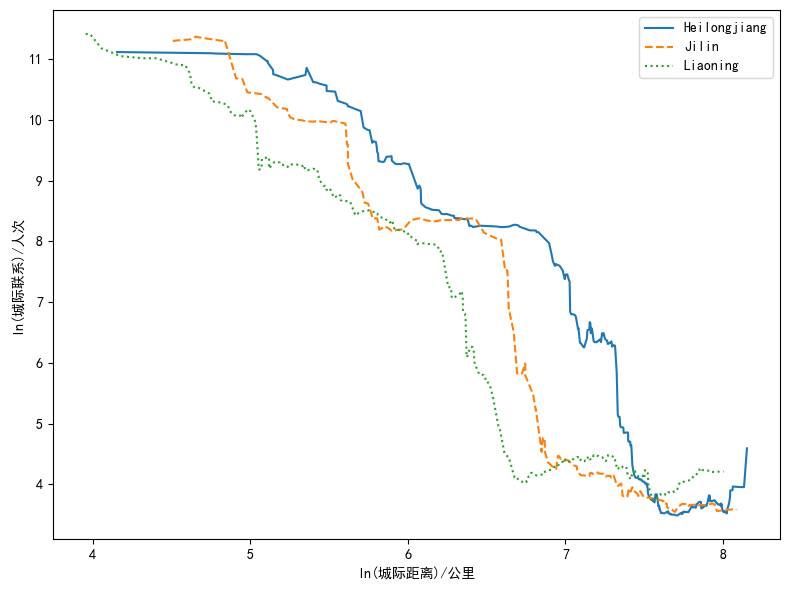

In [23]:
# 创建GBDT回归模型
model = GradientBoostingRegressor(loss='huber',
                                  n_estimators=1000, 
                                  max_depth=4, 
                                  learning_rate=0.01, 
                                  subsample=0.5, 
                                  min_samples_split=5)

# 训练模型
fit_model_train_result(model, ['Heilongjiang', 'Jilin', 'Liaoning'])


# RandomForestRegressor

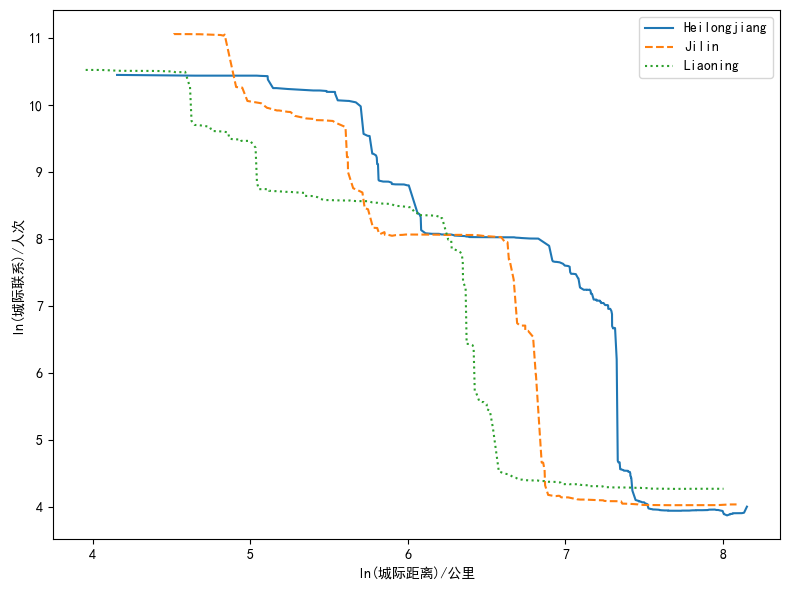

In [24]:
from sklearn.ensemble import RandomForestRegressor

# 创建回归模型
forest_model = RandomForestRegressor(n_estimators=1000, 
                                  max_depth=4,
                                  min_samples_split=5)

# 训练模型
fit_model_train_result(forest_model, ['Heilongjiang', 'Jilin', 'Liaoning'])

# XGBoost

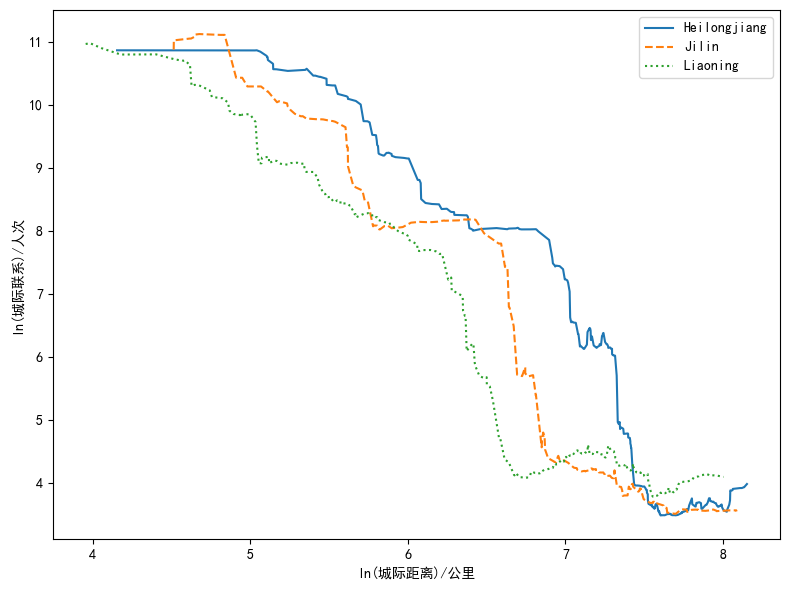

In [25]:
from xgboost import XGBRegressor

xgboost_model = XGBRegressor(n_estimators=1000,
                     max_depth=4,
                     learning_rate=0.01,
                     subsample=0.5)
fit_model_train_result(xgboost_model, ['Heilongjiang', 'Jilin', 'Liaoning'])